In [1]:
from myfunc import stochastic, finfunc
import pandas as pd

In [2]:
# グラフ、桁数表記設定
from myfunc.utility import pref
pref()

<AxesSubplot:>

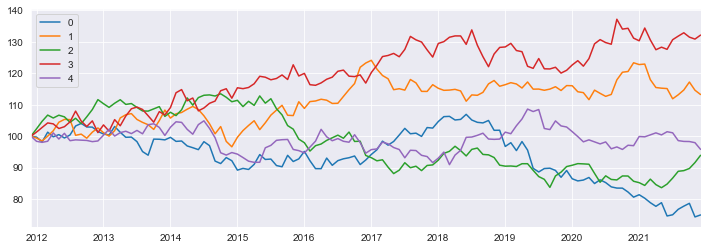

In [3]:
# パスの生成
gbm = stochastic.geometric_brownian_motion(M=120, npath=5)
dates = pd.date_range(end='2021-12-31', periods=len(gbm), freq='BM')
df = pd.DataFrame(gbm, index=dates)
df.plot()

In [4]:
ts = pd.DataFrame({'price': df.iloc[:, 0]})
ts['return'] = ts['price'].pct_change()
ts

,price,return
2011-12-30,100.000000,NaN
2012-01-31,99.707034,-0.002930
2012-02-29,98.172925,-0.015386
2012-03-30,101.275192,0.031600
2012-04-30,99.800798,-0.014558
...,...,...
2021-08-31,76.742393,0.023125
2021-09-30,77.748452,0.013110
2021-10-29,78.646970,0.011557
2021-11-30,74.326498,-0.054935


In [5]:
ts[['mean', 'var', 'skew', 'kurt']] = finfunc.rolling_mvsk(
    ts['return'], window=12)[['mean', 'var', 'skew', 'kurt']]

In [6]:
ts

,price,return,mean,var,skew,kurt
2011-12-30,100.000000,NaN,NaN,NaN,NaN,NaN
2012-01-31,99.707034,-0.002930,NaN,NaN,NaN,NaN
2012-02-29,98.172925,-0.015386,NaN,NaN,NaN,NaN
2012-03-30,101.275192,0.031600,NaN,NaN,NaN,NaN
2012-04-30,99.800798,-0.014558,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2021-08-31,76.742393,0.023125,-0.007194,0.000408,-0.778575,1.551384
2021-09-30,77.748452,0.013110,-0.005720,0.000442,-0.844034,1.141765
2021-10-29,78.646970,0.011557,-0.004737,0.000465,-0.891186,0.912685
2021-11-30,74.326498,-0.054935,-0.008086,0.000673,-0.828721,-0.256103


In [7]:
df.apply(lambda x: finfunc.hurst(x.dropna()))

0    0.040080
1   -0.034090
2    0.012290
3    0.014717
4   -0.043551
dtype: float64

(<Figure size 864x288 with 1 Axes>, <Figure size 864x288 with 1 Axes>)

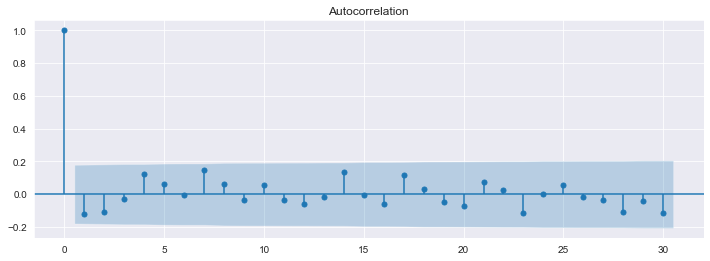

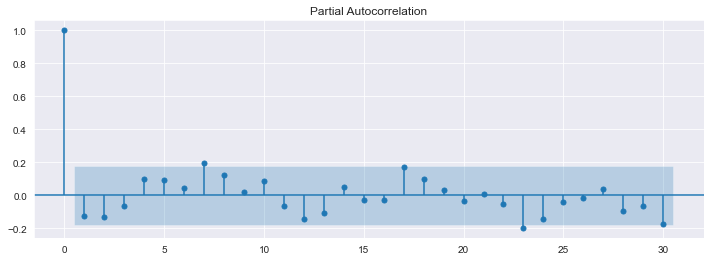

In [8]:
ts_r = ts['return'].dropna()
finfunc.acf_plot(ts_r)

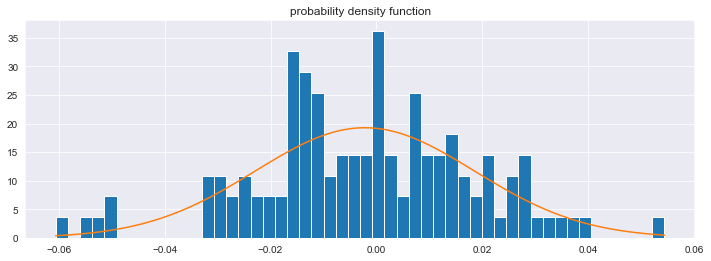

In [9]:
finfunc.histgram_pdf(ts_r)

<AxesSubplot:xlabel='freq/y'>

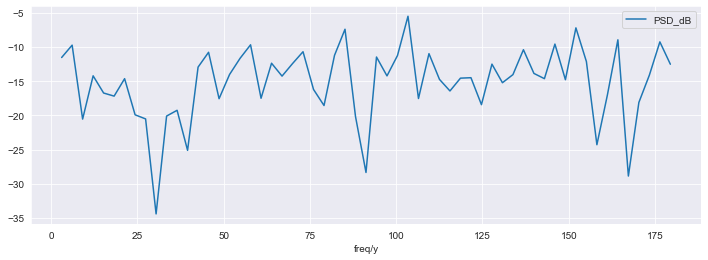

In [10]:
finfunc.fast_Fourier_transform_psd(ts_r.values).plot(legend=True)

<AxesSubplot:>

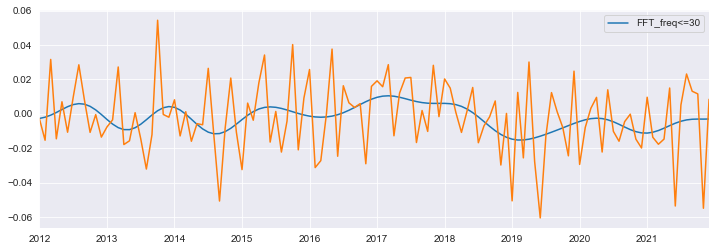

In [11]:
finfunc.fast_Fourier_transform(ts_r, freq_cut=30).plot(legend=True)
ts_r.plot()

<AxesSubplot:>

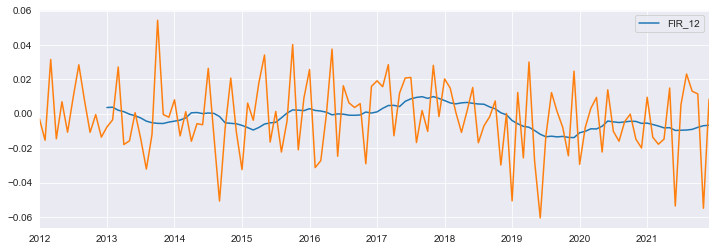

In [12]:
finfunc.filter_finite_impulse_response(ts_r, window=12).plot(legend=True)
ts_r.plot()

<AxesSubplot:>

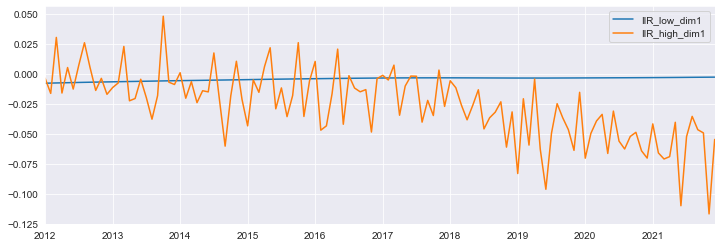

In [13]:
finfunc.filter_IIR_Butterworth(ts_r, dimension=1).plot(legend=True)

In [14]:
# rolling features
w = 12
l_ = list()
for i in range(w, len(ts_r)):
    x = ts_r[i-w:i]
    l_.append((
        finfunc.fast_Fourier_transform(x, freq_cut=30)[-1],
        finfunc.filter_finite_impulse_response(x, window=6)[-1],
        finfunc.filter_IIR_Butterworth(x, dimension=1).iloc[0, -1],
        finfunc.filter_IIR_Butterworth(x, dimension=1).iloc[1, -1],
    ))

ts = ts.join(
    pd.DataFrame(l_,
                 columns=['fft', 'fir', 'iir_low', 'iir_high'], index=ts_r.index[w:])
)

In [15]:
import statsmodels.api as sm
SARIMA_fit = sm.tsa.SARIMAX(ts_r, order=(
    3, 1, 2), seasonal_order=(1, 1, 1, 12)).fit()
SARIMA_fit.summary()

/Users/user/.pyenv/versions/3.7.8/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/user/.pyenv/versions/3.7.8/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.65140D+00    |proj g|=  9.05331D+00

At iterate    5    f= -1.68167D+00    |proj g|=  3.87543D+00

At iterate   10    f= -1.98366D+00    |proj g|=  1.17766D+00

At iterate   15    f= -2.01651D+00    |proj g|=  3.69516D+00

At iterate   20    f= -2.04991D+00    |proj g|=  6.42898D-02

At iterate   25    f= -2.06782D+00    |proj g|=  7.11689D-02

At iterate   30    f= -2.07682D+00    |proj g|=  2.44132D-01

At iterate   35    f= -2.07820D+00    |proj g|=  8.21241D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/user/.pyenv/versions/3.7.8/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



At iterate   40    f= -2.07976D+00    |proj g|=  3.77906D-01

At iterate   45    f= -2.07994D+00    |proj g|=  1.12222D-02

At iterate   50    f= -2.07996D+00    |proj g|=  1.64470D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     84      2     0     0   1.645D-01  -2.080D+00
  F =  -2.0799585817461970     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                               return   No. Observations:                  120
Model:             SARIMAX(3, 1, 2)x(1, 1, [1], 12)   Log Likelihood                 249.595
Date:                              Sat, 19 Feb 2022   AIC                           -483.190
Time:                                      13:37:45   BIC                           -461.807
Sample:                                  01-31-2012   HQIC                          -474.522
                                       - 12-31-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6250      0.474     -1.318      0.187      -1.554       0.304
ar.L2         -0.3047      0.152     -2.008      0.045      -0.602      -0.007
ar.L3         -0.2442      0.128     -1.903      0.057      -0.496       0.007
ma.L1         -0.4492      0.487     -0.923      0.356      -1.403       0.504
ma.L2         -0.3874      0.452     -0.857      0.391      -1.273       0.498
ar.S.L12      -0.1136      0.139     -0.817      0.414      -0.386       0.159
ma.S.L12      -0.9007      0.356     -2.530      0.011      -1.598      -0.203
sigma2         0.0004      0.000      3.217      0.001       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.46
Prob(Q):                              0.87   Prob(JB):                         0.48
Heteroskedasticity (H):               1.23   Skew:                            -0.26
Prob(H) (two-sided):                  0.54   Kurtosis:                         2.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/user/.pyenv/versions/3.7.8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:>

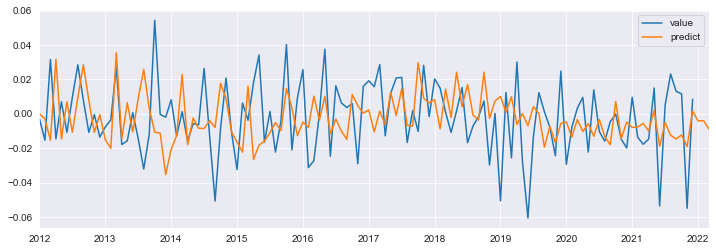

In [16]:
finfunc.statmodels_predict(SARIMA_fit, 3).plot()

<AxesSubplot:>

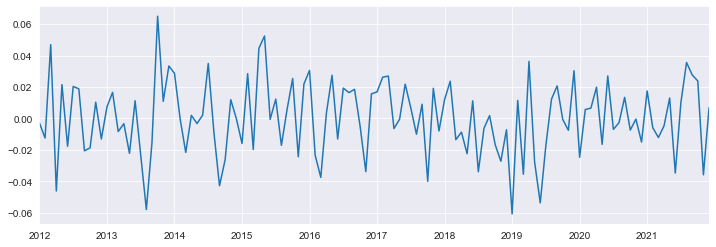

In [17]:
SARIMA_fit.resid.plot()

(<Figure size 864x288 with 1 Axes>, <Figure size 864x288 with 1 Axes>)

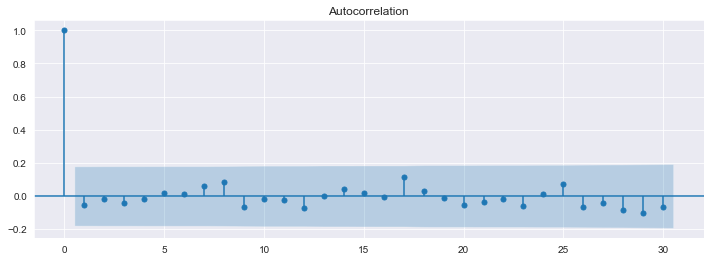

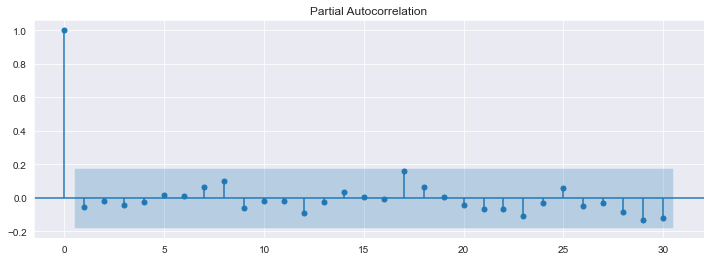

In [18]:
finfunc.acf_plot(SARIMA_fit.resid)

In [19]:
from sklearn.model_selection import train_test_split
ts_target = ts.shift(-1).dropna().iloc[1:, 1]  # 1month delay
ts_features = ts.dropna().iloc[:-1, 2:]  # 1month cut
ts_train_test = train_test_split(
    ts_features, ts_target, random_state=0, shuffle=False, test_size=0.2)

In [20]:
ts_features.tail(3)

,mean,var,skew,kurt,fft,fir,iir_low,iir_high
2021-09-30,-0.005720,0.000442,-0.844034,1.141765,-0.007194,-0.009813,-0.050930,-0.047264
2021-10-29,-0.004737,0.000465,-0.891186,0.912685,-0.005720,-0.008287,-0.035958,-0.050856
2021-11-30,-0.008086,0.000673,-0.828721,-0.256103,-0.004737,-0.000223,-0.033520,-0.039714


features_model         DummyRegressor()
score                             -0.04
n_features_original                   8
coef                               None
intercept                          None
dtype: object


<AxesSubplot:>

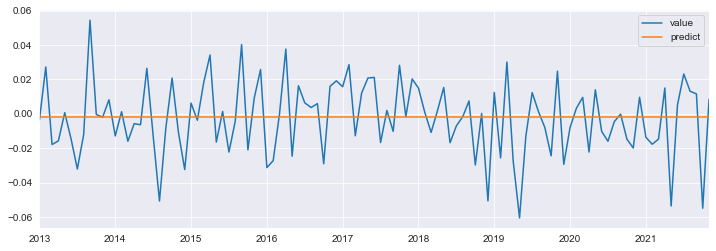

In [21]:
from sklearn.dummy import DummyRegressor
dummy = DummyRegressor(strategy='mean')
finfunc.sklearn_predict_regression(dummy, ts_train_test).plot()

features_model                                        LinearRegression()
score                                                                0.0
n_features_original                                                    8
coef                   [-0.53, -0.48, -0.0, -0.0, -0.22, 0.83, 0.03, ...
intercept                                                           -0.0
dtype: object


<AxesSubplot:>

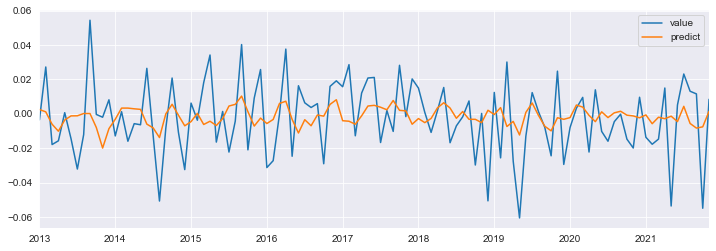

In [22]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression()
finfunc.sklearn_predict_regression(ols, ts_train_test).plot()

features_model                                     Ridge(alpha=0.5)
score                                                         -0.02
n_features_original                                               8
coef                   [0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.01, 0.01]
intercept                                                      -0.0
dtype: object


<AxesSubplot:>

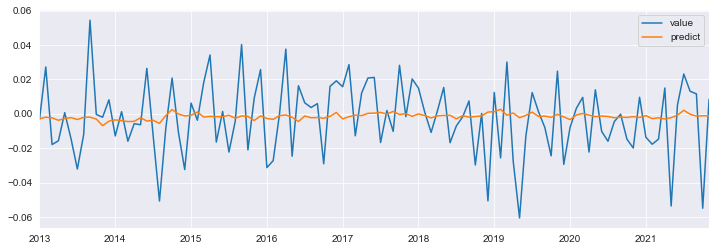

In [23]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.5)
finfunc.sklearn_predict_regression(ridge, ts_train_test).plot()

features_model         RFECV(estimator=LinearRegression(), scoring='n...
score                                                              -0.08
n_features_original                                                    8
coef                                                                None
intercept                                                           None
dtype: object


,mean,var,skew,kurt,fft,fir,iir_low,iir_high
flg,False,True,False,False,False,False,False,False
rank,3,1,7,8,5,2,6,4


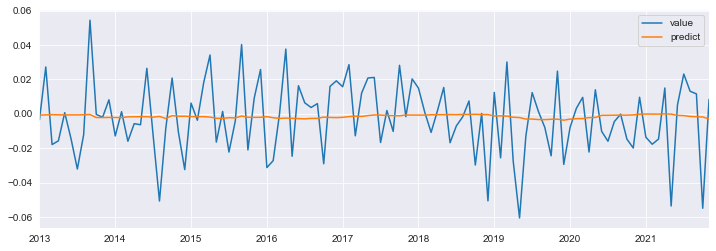

In [24]:
# 再帰的特徴量除去
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=ols, step=1, scoring="neg_mean_squared_error")
finfunc.sklearn_predict_regression(rfecv, ts_train_test).plot()

# 維持すべき特徴量
pd.DataFrame({
    'flg': rfecv.support_,
    'rank': rfecv.ranking_
}, index=ts_train_test[0].columns).T